In [1]:
from numpy import sin, cos
import numpy as np
import matplotlib
%matplotlib inline
#matplotlib.use('TKAgg') # para Mac OSX
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import ffmpeg 

We are trying to solve the geodesic equation and trasport some quantinties.
We first define several functions and set some parameters

In [2]:
M = 1. #mass of black hole. G =
A = 0.5 # angular momentum black hole

N = 1000 # photon numbers

R = 100 # outer radious (up to the point where we integrate)

#p = np.array([])

def flat_sph(p):
    """Computes the metric in spherical coordinates"""
#    g = np.array([],ndmin=2)
    g = np.zeros([4, 4], dtype=np.float64)
    t = p[0]
    r = p[1]
    th = p[2]
    ph = p[3]
    g[0,0]=-1
    g[0,1]=0
    g[0,2]=0
    g[0,3]=0
    g[1,0]=g[0,1]
    g[1,1]=1
    g[1,2]=0
    g[1,3]=0
    g[2,0]=g[0,2]
    g[2,1]=g[1,2]
    g[2,2]=r*r
    g[2,3]=0
    g[3,0]=g[0,3]
    g[3,1]=g[1,3]
    g[3,2]=g[2,3]
    g[3,3]=r*r*np.sin(th)*np.sin(th)
    return g

#p1 = np.array([0,2,1,0])
#flat_sph(p)[2,2]
#flat_sph(p1)

def kerr_iso(p):
    """Computes the metric in spherical coordinates"""
#    g = np.array([],ndmin=2)
    g = np.zeros([4, 4], dtype=np.float64)
    l = np.zeros([4], dtype=np.float64)
    t = p[0]
    x = p[1]
    y = p[2]
    z = p[3]
    rho = x**2 + y**2 + z**2
    A2 = A**2
    r2 = 0.5 * (rho**2 + A2) \
       + np.sqrt(0.25 * (rho**2 - A2)**2 + A2 * z**2)
    r = np.sqrt(r2)
    H2 = 2 * M * r / (r2 + A2 * z**2 / r2)
    l[0] = 1.
    l[1] = (r*x + A*y)/(r2 + A2)
    l[2] = (r*y - A*x)/(r2 + A2)
    l[3] = z/r
    
    g[0,0]=-1. + H2 * l[0]*l[0]
    g[0,1]= 0. + H2 * l[0]*l[1]
    g[0,2]= 0. + H2 * l[0]*l[2]
    g[0,3]= 0. + H2 * l[0]*l[3]
    g[1,0]= g[0,1]
    g[1,1]= 1. + H2 * l[1]*l[1]
    g[1,2]= 0. + H2 * l[1]*l[2]
    g[1,3]= 0. + H2 * l[1]*l[3]
    g[2,0]= g[0,2]
    g[2,1]= g[1,2]
    g[2,2]= 1. + H2 * l[2]*l[2]
    g[2,3]= 0. + H2 * l[2]*l[3]
    g[3,0]= g[0,3]
    g[3,1]= g[1,3]
    g[3,2]= g[2,3]
    g[3,3]= 1  + H2 * l[3]*l[3]
    return g

In [3]:
def flat_Chr_sph(p):
    """Computes the Christoeffel in spherical coordinates"""
    ch = np.zeros([4, 4, 4], dtype=np.float64) # first index is up
    t = p[0]
    r = p[1]
    th = p[2]
    ph = p[3]
    #g = flat_sph(p)
    #we write only the non-zero components
    ch[0,0,0] = 0
    ch[0,0,1] = 0
    ch[0,1,0] = ch[0,0,1]
    ch[0,0,2] = 0
    ch[0,2,0] = ch[0,0,2]
    ch[0,0,3] = 0
    ch[0,3,0] = ch[0,0,3]
    ch[0,1,1] = 0
    ch[0,1,2] = 0
    ch[0,1,3] = 0
    ch[0,3,1] = ch[0,1,3]
    ch[0,2,1] = ch[0,1,2]
    ch[0,2,2] = 0
    ch[0,2,3] = 0
    ch[0,3,2] = ch[0,2,3]
    ch[0,3,3] = 0
    
    ch[1,0,0] = 0
    ch[1,0,1] = 0
    ch[1,1,0] = ch[1,0,1]
    ch[1,0,2] = 0
    ch[1,2,0] = ch[1,0,2]
    ch[1,0,3] = 0
    ch[1,3,0] = ch[1,0,3]
    ch[1,1,1] = 0
    ch[1,1,2] = 0
    ch[1,1,3] = 0
    ch[1,3,1] = ch[1,1,3]
    ch[1,2,1] = ch[1,1,2]
    ch[1,2,2] = -r
    ch[1,2,3] = 0
    ch[1,3,2] = ch[1,2,3]
    ch[1,3,3] = -r*np.sin(th)
   
    ch[2,0,0] = 0
    ch[2,0,1] = 0
    ch[2,1,0] = ch[2,0,1]
    ch[2,0,2] = 0
    ch[2,2,0] = ch[2,0,2]
    ch[2,0,3] = 0
    ch[2,3,0] = ch[2,0,3]
    ch[2,1,1] = 0
    ch[2,1,2] = 1/r
    ch[2,1,3] = 0
    ch[2,3,1] = ch[2,1,3]
    ch[2,2,1] = ch[2,1,2]
    ch[2,2,2] = 0
    ch[2,2,3] = 0
    ch[2,3,2] = ch[2,2,3]
    ch[2,3,3] = -np.sin(th)*np.cos(th)
    
    ch[3,0,0] = 0
    ch[3,0,1] = 0
    ch[3,1,0] = ch[0,0,1]
    ch[3,0,2] = 0
    ch[3,2,0] = ch[0,0,2]
    ch[3,0,3] = 0
    ch[3,3,0] = ch[0,0,3]
    ch[3,1,1] = 0
    ch[3,1,2] = 0
    ch[3,1,3] = 1/r
    ch[3,3,1] = ch[0,1,3]
    ch[3,2,1] = ch[0,1,2]
    ch[3,2,2] = 0
    ch[3,2,3] = np.cos(th)/np.sin(th) #this can become infinite!
    ch[3,3,2] = ch[0,2,3]
    ch[3,3,3] = 0
    return ch

#p = np.array([0,2,1,1])
#flat_Chr(p)[0,1,0]
#flat_Chr(p)


def kerr_Chr_iso(p):
    """Computes the Christoeffel in spherical coordinates"""
    ch = np.zeros([4, 4, 4], dtype=np.float64) # first index is up
    t = p[0]
    x = p[1]
    y = p[2]
    z = p[3]
    r2 = x**2 + y**2 + z**2
    r = np.sqrt(r2)
    #g = kerr_iso(p)
    #we write only the non-zero components
    
    # this is newton only!
    
    ch[0,0,0] = 0
    ch[0,0,1] = 0
    ch[0,1,0] = ch[0,0,1]
    ch[0,0,2] = 0
    ch[0,2,0] = ch[0,0,2]
    ch[0,0,3] = 0
    ch[0,3,0] = ch[0,0,3]
    ch[0,1,1] = 0
    ch[0,1,2] = 0
    ch[0,1,3] = 0
    ch[0,3,1] = ch[0,1,3]
    ch[0,2,1] = ch[0,1,2]
    ch[0,2,2] = 0
    ch[0,2,3] = 0
    ch[0,3,2] = ch[0,2,3]
    ch[0,3,3] = 0
    
    ch[1,0,0] = x/r2
    ch[1,0,1] = 0
    ch[1,1,0] = ch[1,0,1]
    ch[1,0,2] = 0
    ch[1,2,0] = ch[1,0,2]
    ch[1,0,3] = 0
    ch[1,3,0] = ch[1,0,3]
    ch[1,1,1] = 0
    ch[1,1,2] = 0
    ch[1,1,3] = 0
    ch[1,3,1] = ch[1,1,3]
    ch[1,2,1] = ch[1,1,2]
    ch[1,2,2] = 0
    ch[1,2,3] = 0
    ch[1,3,2] = ch[1,2,3]
    ch[1,3,3] = 0
   
    ch[2,0,0] = y/r2
    ch[2,0,1] = 0
    ch[2,1,0] = ch[2,0,1]
    ch[2,0,2] = 0
    ch[2,2,0] = ch[2,0,2]
    ch[2,0,3] = 0
    ch[2,3,0] = ch[2,0,3]
    ch[2,1,1] = 0
    ch[2,1,2] = 0
    ch[2,1,3] = 0
    ch[2,3,1] = ch[2,1,3]
    ch[2,2,1] = ch[2,1,2]
    ch[2,2,2] = 0
    ch[2,2,3] = 0
    ch[2,3,2] = ch[2,2,3]
    ch[2,3,3] = 0
    
    ch[3,0,0] = z/r2
    ch[3,0,1] = 0
    ch[3,1,0] = ch[0,0,1]
    ch[3,0,2] = 0
    ch[3,2,0] = ch[0,0,2]
    ch[3,0,3] = 0
    ch[3,3,0] = ch[0,0,3]
    ch[3,1,1] = 0
    ch[3,1,2] = 0
    ch[3,1,3] = 0
    ch[3,3,1] = ch[0,1,3]
    ch[3,2,1] = ch[0,1,2]
    ch[3,2,2] = 0
    ch[3,2,3] = 0
    ch[3,3,2] = ch[0,2,3]
    ch[3,3,3] = 0
    return ch



In [4]:
def vector_contract(vu, vd):
    return vu[0]*vd[0] + vu[1]*vd[1] + vu[2]*vd[2] + vu[3]*vd[3] 

def vector_down(vu, g):
    vd = np.zeros([4], dtype=np.float64)
    vd[0] = g[0,0] * vu[0] + g[0,1] * vu[1] \
    + g[0,2] * vu[2] + g[0,3] * vu[3]
    
    vd[1] = g[1,0] * vu[0] + g[1,1] * vu[1] \
    + g[1,2] * vu[2] + g[1,3] * vu[3]
        
    vd[2] = g[2,0] * vu[0] + g[2,1] * vu[1] \
    + g[2,2] * vu[2] + g[2,3] * vu[3]
            
    vd[3] = g[3,0] * vu[0] + g[3,1] * vu[1] \
    + g[3,2] * vu[2] + g[3,3] * vu[3]
    
    return vd
    

In [5]:
def generate_initial_point():
    """here we generate a random point in some given region. NOT DONE!"""
    p = np.zeros([4], dtype=np.float64)
    x = np.zeros([4], dtype=np.float64)
    p[0] = 0.
    p[1] = 5.
    p[2] = 0.
    p[3] = 0.
    
    x = np.random.rand(4)
    p = p + x
    p[0] = 0.
    return p

def car_to_sph(xp,xc):
    """apply the jacovian at the given point"""
    
    
    return xp

def nullify(v,t,g):
    """take a vector and produces a null vector with the same angular direction
    There are serveral ways to do this, none is frame independent, so here we add 
    another vector field, time-like, to make this splitting. It should be some rest
    frame vector at the source"""
    vs = np.zeros([4], dtype=np.float64)
    vn = np.zeros([4], dtype=np.float64)
    td = vector_down(t,g)
    nt = vector_contract(t,td)
    vtd = vector_contract(v,td)
    
    vs = v - t * vtd / nt
#    vs[0] = v[0] - t[0] * vtd/nt
#    vs[1] = v[1] - t[1] * vtd/nt
#    vs[2] = v[2] - t[2] * vtd/nt
#    vs[3] = v[3] - t[3] * vtd/nt
    
    vsd = vector_down(vs,g)
    nvs = vector_contract(vs,vsd)
    omega = np.sqrt(-nvs/nt)
    
    vn = omega * t + vs
#    vn[0] = omega * t[0] + vs[0]
#    vn[1] = omega * t[1] + vs[1]
#    vn[2] = omega * t[2] + vs[2]
#    vn[3] = omega * t[3] + vs[3]
    
    return vn
    

def generate_initial_velocity(p,g,t):
    """here we generate a random null vector with unit time component, NOT DONE"""
    #g = (p)
    v = np.zeros([4], dtype=np.float64)
    #x = np.zeros([4], dtype=np.float64)

    # for making an homogeneous vector distribution we do first in cartesian coordinates
    # in any case this is not an homogeneous distribution on the sphere!
    
    v = -1 + 2*np.random.rand(4)
    
    v = 20*t + v #forces the vector to be time-like and future directed
    
    vn = nullify(v,t,g)
    
    return vn

In [6]:
def local_intensity(p,omega):
    """This is a local funcition giving the intensity for each point as a \
    function of the frequency"""
    return Iloc

def add_intensity(I,N,p):
    """This add the observed intensity to the frequency tuple.
    The idea is there is a set of frequencies at each patch
    in the infinity sphere and we add intensities from each photon.
    I is a function of tuple of omegas and the pixel (patch on the sphere)
    N is the number of photons reaching the patch.
    This function evolves an initial data, determine the patch where it arrives,
    transform back the frequencies and get the local intensities at the local frequencies
    and then get the observed intensities at the given frequencies"""
    return

In [7]:
def derivs(t,u):
    """this is the right hand side of the geodesic equation \
    u = (x0,x1,x2,x3,v0,v1,v2,v3)"""
    rhs = np.empty([8], dtype=np.float64)
    p = u[:4] # get the point only
    v = u[4:8] #get the velocities only
    Chr = kerr_Chr_iso(p) #get the Christofells
    #first the velocities p_t
    rhs[0:4] = v
#    rhs[0] = v[0]
#    rhs[1] = v[1]
#    rhs[2] = v[2]
#    rhs[3] = v[3]
    #now the acceleration v_t
    for i in range(4):
        for j in range(4):
            for k in range(4):
                rhs[i+4] = rhs[i+4] - Chr[i,j,k]*v[j]*v[k]
    return rhs

In [8]:
#u = [1,2,3,4,5,6,7,8]
#p = u[:4]
#v = u[4:8]
#p,v

In [22]:
u0 = np.zeros([8], dtype=np.float64)
t = np.zeros([4], dtype=np.float64)

# caso de prueba, en el plano z = 0
u0[0] = 0
u0[1] = 10
u0[2] = 0
u0[3] = 0
u0[4] = 1
u0[5] = 0.
u0[6] = 0.01
u0[7] = 0.

t[0] = 1

#print("t = ",t)
p1 = generate_initial_point()
#print("point = ",p1)
v1 = generate_initial_velocity(p1,kerr_iso(p1),t)
#print("velocity = ", v1)
u1 = np.concatenate((p1, v1), axis=None)
u1

#print("metric = ", kerr_iso(p1))

array([ 0.        ,  5.84778453,  0.20910294,  0.99434548,  0.54551924,
        0.12455974,  0.47310189, -0.20076167])

In [23]:
#u0[:4]

In [24]:
#kerr_Chr_iso(u1[:4])

In [25]:
derivs(0,u0)

array([ 1.        ,  0.        ,  0.01      ,  0.        ,  0.54551924,
        0.02455974,  0.47310189, -0.20076167])

In [26]:
# plot
K=50001
X = np.zeros([K,3])

In [27]:
#integrate your ODE using scipy.integrate.
#sol = integrate.ode(derivs).set_integrator('dopri5', nsteps=1000)  # Runge Kutta de orden 4/5
sol = integrate.ode(derivs).set_integrator('dop853', nsteps=10000)   # Runge Kutta de orden 8
sol.rtol = 1.e-12
sol.set_initial_value(u0, 0)

dt = 0.001
sol.t = 0
r = 3

i = 0
X[0] = u1[1:4]

while sol.successful() and r < R:
    i=i+1
    y = sol.integrate(sol.t+dt)
    X[i] = y[1:4]
    r = np.sqrt(y[1]**2 + y[2]**2 + y[3]**2)

    #print(y)
    #print(y[1],r)


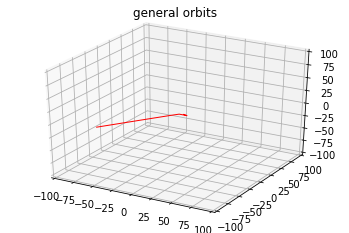

In [28]:
# Finalmente graficamos la solucion    
plt.ioff()
ax = plt.subplot(111, projection='3d')
ax.grid(True)
ax.set_title("general orbits", va='bottom')
#ax.figsize = (20,20)

# cambiar para ajustar mejor el gráfico

ax.set_xlim((-100, 100))
ax.set_ylim((-100, 100))
ax.set_zlim((-100, 100))

ax.plot(X[0:i,0],X[0:i,1],X[0:i,2], color='r', linewidth=1)

plt.show()

In [16]:
print(i)

66
